In [1]:
!pip install --upgrade tqdm opencv-python einops seaborn tensorflow[and-cuda] imageio

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached tensorflow-2.19.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached pandas-2.3.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached matplotlib-3.10.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached absl_py-2.3.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 byt

In [2]:
import pathlib
import collections

import cv2
import einops
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

import imageio.v3 as iio
from IPython.display import Image, display, HTML
# from urllib import request
# from tensorflow_docs.vis import embed

import time

2025-06-06 19:00:48.567215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749229248.781844   52890 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749229248.852530   52890 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749229249.365602   52890 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749229249.365634   52890 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749229249.365636   52890 computation_placer.cc:177] computation placer alr

In [3]:
DATA_DIR = pathlib.Path('./data')
TRAIN_PATH = DATA_DIR / 'train'
VALIDATION_PATH = DATA_DIR / 'validation'
TEST_PATH = DATA_DIR / 'test'

LABELS = [d.name for d in TRAIN_PATH.iterdir() if d.is_dir()]
print(f'LABELS: {LABELS}')

# Define the dimensions of one frame in the set of frames created
HEIGHT = 160
WIDTH = 160

N_FRAMES = 20
FRAME_STEP = 4

def get_class(fname):
  """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the dataset. Example name: 'apfel_train_0.mp4'

    Returns:
      Class that the file belongs to.
  """
  return fname.split('_')[-2]

def get_files_per_class(files):
  """ Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Returns:
      Dictionary of class names (key) and files (values). 
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (WIDTH,HEIGHT), frame_step = FRAME_STEP):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = int(src.get(cv2.CAP_PROP_FRAME_COUNT))
  
  frame_idx = 0
  read_frame_idx = 0

  # add first frame
  src.set(cv2.CAP_PROP_POS_FRAMES, 0)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))
  
  while frame_idx < N_FRAMES - 1:
    # skip frame_step frames
    for _ in range(frame_step):
      ret, frame = src.read()
    
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      # Reached end, loop back to start
      src.set(cv2.CAP_PROP_POS_FRAMES, 0)
      read_frame_idx = 0
      continue
      
    frame_idx += 1
    read_frame_idx += 1
  

  # for _ in range(n_frames - 1):
  #   for _ in range(frame_step):
  #     ret, frame = src.read()
  #   if ret:
  #     frame = format_frames(frame, output_size)
  #     result.append(frame)
  #   else:
  #     result.append(np.zeros_like(result[0]))
  
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

def to_gif(images, filename):
  """
  Converts images into a gif file.
  
  Args:
    images: The images to convert into a gif.
    filename: The name of the resulting file.
  
  Return:
    The path to the resulting file.
  """
  gif_dir = pathlib.Path('./gif')
  gif_dir.mkdir(exist_ok=True)

  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  gif_path = gif_dir / f'{filename}.gif'
  
  iio.imwrite(gif_path, converted_images, fps=24 / FRAME_STEP, loop=0)
  return gif_path

def display_gif_grid(gif_paths, cols_per_row=15, gif_width=100):
    """
    Displays GIFs in a grid with their filenames as labels.
    
    Parameters:
    - gif_paths: Paths to GIF files.
    - cols_per_row: Number of GIFs per row.
    - gif_width: Width of each GIF in pixels.
    """
    
    html = "<table style='border-collapse: collapse;'>"

    for i in range(0, len(gif_paths), cols_per_row):
        html += "<tr>"
        for gif in gif_paths[i:i+cols_per_row]:
            html += f"""
                <td style="text-align: center; padding: 10px;">
                    <img src="{gif}?{int(time.time())}" width="{gif_width}"><br>
                    <div style="font-size: 14px; margin-top: 5px;">{gif.stem}</div>
                </td>
            """
        html += "</tr>"

    html += "</table>"
    display(HTML(html))

LABELS: ['ananas', 'apfel', 'banane', 'erdbeere', 'fleisch', 'himbeere', 'kiwi', 'paprika', 'tomate', 'zwiebel']


In [4]:
convert_to_gifs = True

train_gif_paths = []
val_gif_paths = []
test_gif_paths = []

if convert_to_gifs:
    gif_dir = pathlib.Path('./gif')
    for gif_file in gif_dir.glob('*.gif'):
      gif_file.unlink()
      
    for label in LABELS:
        for video_path in list(DATA_DIR.glob(f'train/{label}/*.mp4')):
            train_gif_paths.append(to_gif(frames_from_video_file(video_path, N_FRAMES), video_path.stem))
        for video_path in list(DATA_DIR.glob(f'validation/{label}/*.mp4')):
            val_gif_paths.append(to_gif(frames_from_video_file(video_path, N_FRAMES), video_path.stem))
        for video_path in list(DATA_DIR.glob(f'test/{label}/*.mp4')):
            test_gif_paths.append(to_gif(frames_from_video_file(video_path, N_FRAMES), video_path.stem))
else:
    train_gif_paths = list(pathlib.Path('./gif').glob('*train*.gif'))
    val_gif_paths = list(pathlib.Path('./gif').glob('*validation*.gif'))
    test_gif_paths = list(pathlib.Path('./gif').glob('*test*.gif'))

print(f'train videos: {len(train_gif_paths)}')
display_gif_grid(train_gif_paths)

print(f'validation videos: {len(val_gif_paths)}')
display_gif_grid(val_gif_paths)

print(f'test videos: {len(test_gif_paths)}')
display_gif_grid(test_gif_paths)

I0000 00:00:1749229282.573977   52890 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4056 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


train videos: 140


validation videos: 20


test videos: 20


In [5]:
class FrameGenerator:
  def __init__(self, path, n_frames):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
    """
    self.path = path
    self.n_frames = n_frames
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [6]:
batch_size = 8

# Create training/test set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(TRAIN_PATH, N_FRAMES),
                                          output_signature = output_signature)
val_ds = tf.data.Dataset.from_generator(FrameGenerator(VALIDATION_PATH, N_FRAMES),
                                          output_signature = output_signature)
test_ds = tf.data.Dataset.from_generator(FrameGenerator(TEST_PATH, N_FRAMES),
                                        output_signature = output_signature)

# Batch the data
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of test set of frames: {test_frames.shape}')
print(f'Shape of test labels: {test_labels.shape}')


2025-06-06 19:03:04.523896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 7 of 1000
2025-06-06 19:03:21.986333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


Shape of training set of frames: (8, 20, 160, 160, 3)
Shape of training labels: (8,)
Shape of validation set of frames: (8, 20, 160, 160, 3)
Shape of validation labels: (8,)
Shape of test set of frames: (4, 20, 160, 160, 3)
Shape of test labels: (4,)


In [7]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [8]:
input_shape = (None, N_FRAMES, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(len(LABELS))(x)

model = keras.Model(input, x)

In [9]:
frames, label = next(iter(train_ds))
model.build(frames)

# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [10]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [11]:
history = model.fit(x = train_ds,
                    epochs = 5, 
                    validation_data = val_ds)

Epoch 1/5


I0000 00:00:1749229419.766619   54614 service.cc:152] XLA service 0x7007f4004470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749229419.766659   54614 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-06-06 19:03:40.072829: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749229421.608853   54614 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-06 19:03:43.871484: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-06 19:03:44.029411: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, p

     17/Unknown 31s 211ms/step - accuracy: 0.1231 - loss: 3.3361

2025-06-06 19:04:04.898395: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-06 19:04:05.041815: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


     18/Unknown 47s 1s/step - accuracy: 0.1206 - loss: 3.3523   

2025-06-06 19:04:19.452229: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-06 19:04:19.452336: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/mnt/c/Users/BigBoi/Desktop/FP/fp-team-2-sose25/model/food/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


18/18 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.1184 - loss: 3.3668 - val_accuracy: 0.1000 - val_loss: 2.6743
Epoch 2/5


2025-06-06 19:04:24.007131: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.2006 - loss: 2.6273 - val_accuracy: 0.1000 - val_loss: 2.5138
Epoch 3/5


2025-06-06 19:04:27.882155: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.2371 - loss: 2.4449 - val_accuracy: 0.1500 - val_loss: 2.4279
Epoch 4/5


2025-06-06 19:04:31.710154: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5935811693405028473
2025-06-06 19:04:31.710210: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 253364951537303467


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.0414 - loss: 2.4342 - val_accuracy: 0.1000 - val_loss: 2.3855
Epoch 5/5


2025-06-06 19:04:35.585343: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - accuracy: 0.0312 - loss: 2.6165 - val_accuracy: 0.2000 - val_loss: 2.3836


2025-06-06 19:04:39.440877: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5935811693405028473
2025-06-06 19:04:39.440937: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 253364951537303467


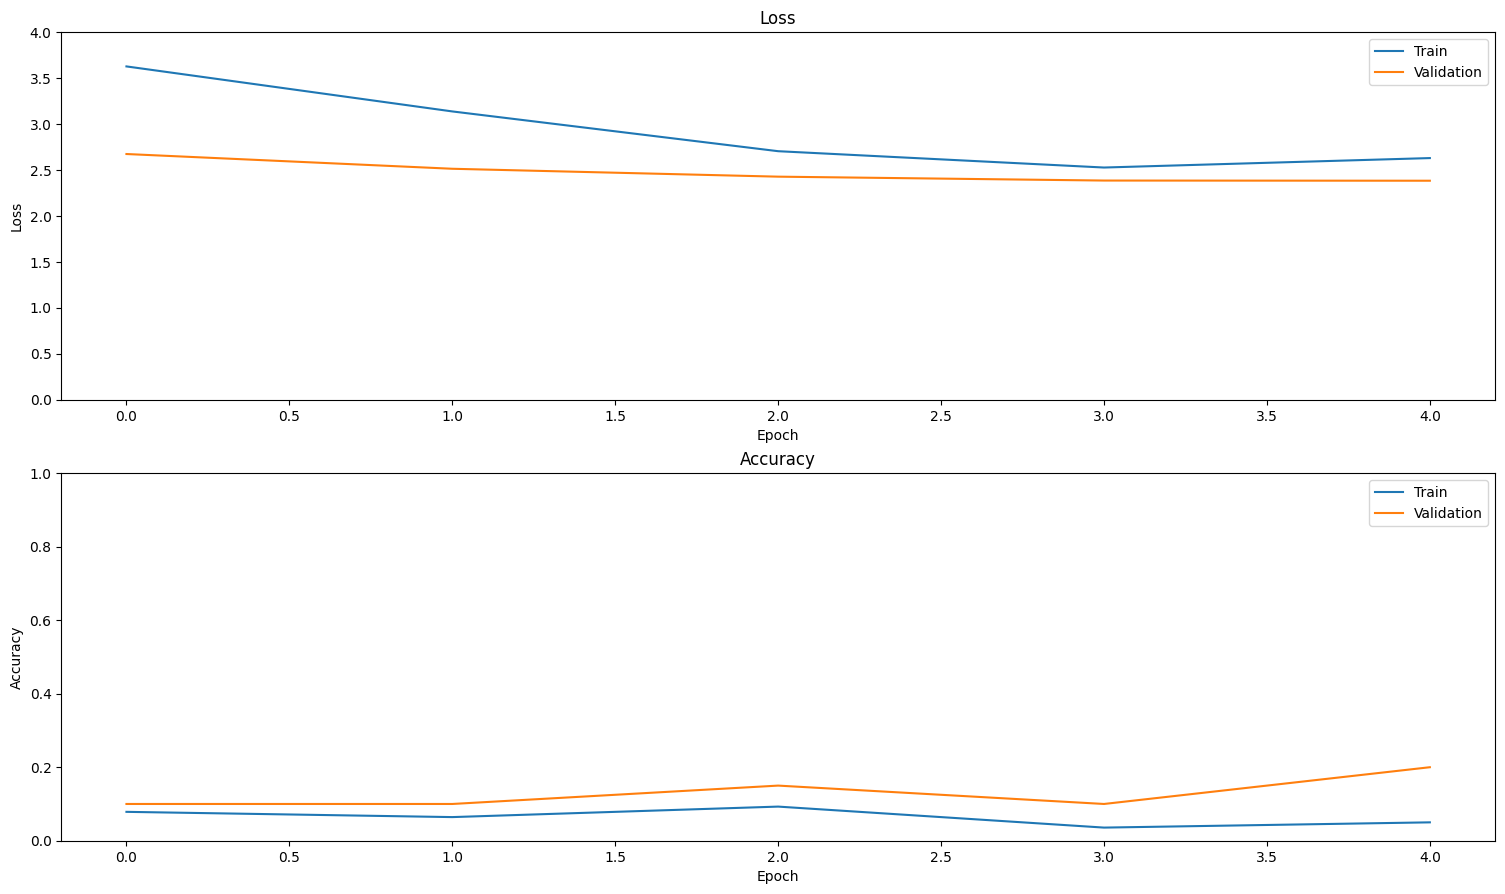

In [12]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

In [13]:
model.evaluate(test_ds, return_dict=True)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1021 - loss: 2.4141


{'accuracy': 0.10000000149011612, 'loss': 2.389361619949341}

In [14]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


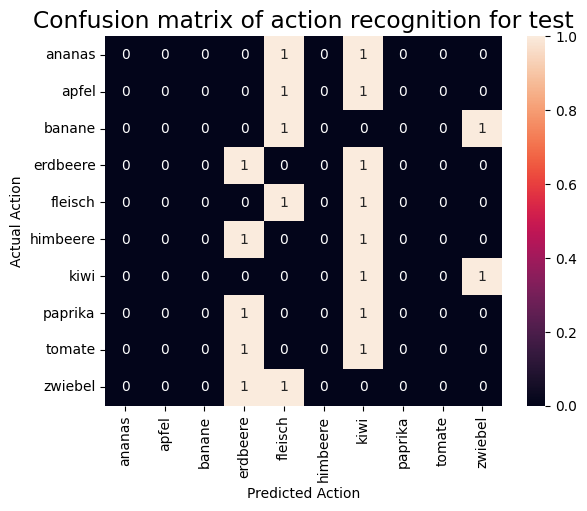

In [15]:
fg = FrameGenerator(TRAIN_PATH, N_FRAMES)
labels = list(fg.class_ids_for_name.keys())

actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [16]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall

In [17]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

/tmp/ipykernel_52890/3092751621.py:25: RuntimeWarning: invalid value encountered in scalar divide
  precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision


In [18]:
precision

{'ananas': np.float64(nan),
 'apfel': np.float64(nan),
 'banane': np.float64(nan),
 'erdbeere': np.float64(0.2),
 'fleisch': np.float64(0.2),
 'himbeere': np.float64(nan),
 'kiwi': np.float64(0.125),
 'paprika': np.float64(nan),
 'tomate': np.float64(nan),
 'zwiebel': np.float64(0.0)}

In [19]:
recall

{'ananas': np.float64(0.0),
 'apfel': np.float64(0.0),
 'banane': np.float64(0.0),
 'erdbeere': np.float64(0.5),
 'fleisch': np.float64(0.5),
 'himbeere': np.float64(0.0),
 'kiwi': np.float64(0.5),
 'paprika': np.float64(0.0),
 'tomate': np.float64(0.0),
 'zwiebel': np.float64(0.0)}